<a href="https://colab.research.google.com/github/mot1122/study_pytorch/blob/main/2_2_2_3_Dataset_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os.path as osp
import random
import numpy as np

import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [5]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [6]:
def make_datapath_list(rootpath):
  imgpath_template=osp.join(rootpath,"JPEGImages","%s.jpg")
  annopath_template=osp.join(rootpath,"Annotations","%s.xml")
  train_id_names=osp.join(rootpath,"ImageSets/Main/train.txt")
  val_id_names=osp.join(rootpath,"ImageSets/Main/val.txt")
  
  train_img_list,train_anno_list=[],[]
  for line in open(train_id_names):
    file_id=line.strip()
    img_path=(imgpath_template % file_id)
    anno_path=(annopath_template % file_id)
    train_img_list.append(img_path)
    train_anno_list.append(anno_path)
  
  val_img_list,val_anno_list=[],[]
  for line in open(val_id_names):
    file_id=line.strip()
    img_path=(imgpath_template % file_id)
    anno_path=(annopath_template % file_id)
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)
  
  return train_img_list,train_anno_list, val_img_list,val_anno_list

In [7]:
rootpath="/content/drive/MyDrive/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/"
train_img_list,train_anno_list, val_img_list,val_anno_list=make_datapath_list(rootpath)
print(train_img_list[0])

/content/drive/MyDrive/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [8]:
import xml.etree.ElementTree as ET

In [9]:
class Anno_xml2list(object):
  def __init__(self,classes):
    self.classes=classes
  def __call__(self,xml_path,width,height):
    lis=[]
    xml=ET.parse(xml_path).getroot()
    for obj in xml.iter("object"):
      difficult=int(obj.find("difficult").text)
      if difficult==1:continue
      bndbox=[]
      name=obj.find("name").text.lower().strip()
      bbox=obj.find("bndbox")
      pts=['xmin', 'ymin', 'xmax', 'ymax']
      for pt in pts:
        cur_pixel=int(bbox.find(pt).text)-1
        if pt=="x_min" or pt=="x_max":cur_pixel/=width
        else:cur_pixel/=height
        bndbox.append(cur_pixel)
      label_idx=self.classes.index(name)
      bndbox.append(label_idx)
      lis+=[bndbox]
    return np.array(lis)

In [10]:
voc_classes=['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
transform2list=Anno_xml2list(voc_classes)

In [11]:
idx=1
img_file_path=val_img_list[idx]
img=cv2.imread(img_file_path)
height,width,channels=img.shape

In [12]:
# transform2list(val_anno_list[idx],width,height)

array([[ 0.13513514,  0.03003003,  1.4984985 ,  0.996997  , 18.        ],
       [ 0.18318318,  0.56756757,  0.24624625,  0.72672673, 14.        ]])

In [13]:
cp /content/drive/MyDrive/pytorch_advanced/2_objectdetection/utils/data_augumentation.py data_augumentation.py

In [14]:
from data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

In [15]:
class DataTransform():
  def __init__(self,input_size,color_mean):
    self.data_transform={
        "train":Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
        ]),
        "val":Compose([
          ConvertFromInts(),
          Resize(input_size),
          SubtractMeans(color_mean)
        ])
    }
  def __call__(self,img,phase,boxes,labels):
    return self.data_transform[phase](img,boxes,labels)

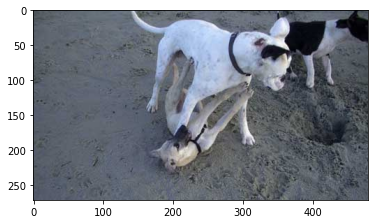

/content/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


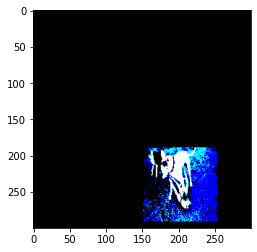

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


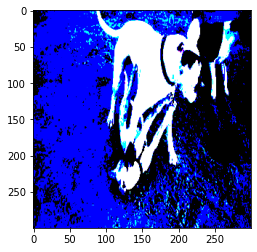

In [21]:
img=cv2.imread(train_img_list[2])
height,width,color=img.shape

anno2list=transform2list(train_anno_list[1],width,height)
boxes=anno2list[:,:4]
labels=anno2list[:,4]

input_size,color_mean=300, (104, 117, 123)
transform=DataTransform(input_size,color_mean)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

for phase in ["train","val"]:
  transformed_img,boxes,labels=transform(img,phase,boxes,labels)
  plt.imshow(cv2.cvtColor(transformed_img,cv2.COLOR_BGR2RGB))
  plt.show()

In [31]:
class VOCDataset(data.Dataset):
  def __init__(self,img_path, anno_path, phase, transform=
               DataTransform(input_size, color_mean),anno2list=Anno_xml2list(voc_classes)):
    self.img_path=img_path
    self.anno_path=anno_path
    self.phase=phase
    self.transform=transform
    self.anno2list=anno2list
  def __len__(self):
    return len(self.img_path)
  def __getitem__(self,idx):
    return self.pull_item(idx)
  def pull_item(self,idx):
    img=cv2.imread(self.img_path[idx])
    height,width,color=img.shape
    anno_info=self.anno2list(self.anno_path[idx],width,height)
    boxes,labels=anno_info[:,:4],anno_info[:,4]
    img,boxes,labels=self.transform(img,self.phase,boxes,labels)
    img=torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)
    anno_info=np.hstack((boxes,np.expand_dims(labels,axis=1)))
    return img, anno_info

In [38]:
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train")
val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val")

train_dataset[2]

/content/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)


(tensor([[[-44.0226, -47.8340, -49.4432,  ..., -29.0251, -29.2317, -29.2317],
          [-43.5450, -47.4376, -49.5785,  ..., -28.5474, -28.7540, -28.3035],
          [-42.6912, -46.8662, -49.0299,  ..., -27.7638, -28.1398, -27.5046],
          ...,
          [-47.3742, -49.4254, -49.9314,  ..., -53.3336, -58.0024, -65.2405],
          [-50.3835, -53.3681, -52.3707,  ..., -49.2145, -57.4873, -67.5863],
          [-54.2317, -57.4232, -54.5599,  ..., -46.6113, -56.0448, -65.2793]],
 
         [[-32.9181, -36.7295, -38.3386,  ..., -14.2744, -15.0863, -15.2103],
          [-32.4405, -36.3331, -38.4740,  ..., -13.7968, -14.6086, -15.6338],
          [-31.5866, -35.7616, -37.9254,  ..., -13.2353, -14.0471, -15.5469],
          ...,
          [-36.2697, -38.3208, -38.8269,  ..., -42.2290, -46.8978, -54.1359],
          [-39.2790, -42.2636, -41.2662,  ..., -38.1099, -46.3828, -56.4818],
          [-43.1272, -46.3187, -43.4553,  ..., -35.5068, -44.9403, -54.1748]],
 
         [[-12.6259, -16.437

In [43]:
def od_collate_fn(batch):
  img,anno_info=[],[]
  for sample in batch:
    img.append(sample[0])
    anno_info.append(torch.FloatTensor(sample[1]))
  img=torch.stack(img,dim=0)
  return img,anno_info

In [44]:
batch_size=4
train_dataloader=data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=od_collate_fn)
val_dataloader=data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,collate_fn=od_collate_fn)
dataloaders_dict={"train":train_dataloader,"val":val_dataloader}

In [47]:
batch_iter=iter(dataloaders_dict["val"])
imgs,annos=next(batch_iter)
print(imgs.size())
print(len(annos))
print(annos[0].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])
